In [11]:
import seaborn as sns
sns.set()

<!-- requirement: images/intro_ex.png -->
#  What is Machine Learning?

Machine learning is a broad collection of tools used for finding patterns in data.  Many machine learning tools are used to make predictions about future data.  

For example, we can use ML algorithms to approximate an unknown function or to group data into clusters.

![ex](images/intro_ex.png)

Machine Learning is an area of active research and development and has produced many impressive applications:

* Voice and image recognition
* Translation services
* Financial models
* Spam detection
* Self-driving cars

In this notebook, we are going to give you a small view into the world of machine learning by examining a typical machine learning task, that of *predicting* a value, given data that we have to build a model.  

# Our goal

While this notebook is **not** designed to give you the details of the mathematics behind machine learning, we will consider a real use-case for which machine learning tools can be applied.  

We consider the College Scorecard data you have already seen in the previous notebooks.  Recall that this data has information about university tuition fees for universities in each state, as well as further descriptive data about those universities as well as state income information, etc.  

What we want to do is to find a way to use our data to make a prediction about the average tuition for a university in each state, given the year (and state).  In particular, let's concentrate on public universities that award undergraduate degrees, and see if we can find a way to predict the (average) tuition for such a university in each state.  

In case you haven't downloaded this data, the code in the next cell will retrieve it for you. 

In [82]:
'''
%%bash
wget https://s3.amazonaws.com/dataincubator-course/college-scorecard/CollegeScorecard_Data.zip -nc -q
unzip -u CollegeScorecard_Data.zip
'''

'\n%%bash\nwget https://s3.amazonaws.com/dataincubator-course/college-scorecard/CollegeScorecard_Data.zip -nc -q\nunzip -u CollegeScorecard_Data.zip\n'

We begin the process by first using our pandas knowledge to compute the average tuition score for each state.  Recall that we are only interested in schools that reward undergraduate degrees and are public institutions.  This means we want to limit our data to `CONTROL == 1` and `PREDDEG == 3` in the Scorecard data.  

Similar to the analysis performed in the `EDT_Pandas_Data_Aggregation` notebook, let's first compute average tuition fees for each state for each year and save this information in a DataFrame.  

To facilitate these calculations, we will write a function which will take a file name as input and compute these mean tuition values.  As in the previous notebook, we'll iterate over all of the annual College Scorecard data that we have.  We use the `glob` library we described in the previous notebook to iterate over the Scorecard files.  

In [13]:
import pandas as pd
import numpy as np
import re

In [44]:
def avg_tuition_pub(file_path, verbose=False):
    """
    Compute mean tuition scores for each state, 
    given a file containg tuitions for a given year.
    """
    if verbose:
        print('Processing file: ' + file_path)
        
    df = pd.read_csv(file_path, low_memory=False)
    tuition_pub = (df.query('CONTROL == 1 and PREDDEG ==3')
                    .groupby('STABBR')[['COSTT4_A']].mean())

    year = re.search(r'MERGED(\d+)_', file_path).group(1)
    tuition_pub['year'] = int(year)

    return tuition_pub

In [45]:
def create_pivot(df):
    """Create a pivot table of results."""
    result = (df.pivot(index=None, columns='year', values='COSTT4_A')
                 .applymap(lambda x: round(x,2)))
              
    return result

In [46]:
import glob

files = glob.glob('CollegeScorecard_Data/MERGED2*.zip')
ave_tuitions = (pd.concat([avg_tuition_pub(f, verbose=True) for f in files])
               .dropna().pipe(create_pivot))

Processing file: CollegeScorecard_Data\MERGED2000_01_PP.zip
Processing file: CollegeScorecard_Data\MERGED2001_02_PP.zip
Processing file: CollegeScorecard_Data\MERGED2002_03_PP.zip
Processing file: CollegeScorecard_Data\MERGED2003_04_PP.zip
Processing file: CollegeScorecard_Data\MERGED2004_05_PP.zip
Processing file: CollegeScorecard_Data\MERGED2005_06_PP.zip
Processing file: CollegeScorecard_Data\MERGED2006_07_PP.zip
Processing file: CollegeScorecard_Data\MERGED2007_08_PP.zip
Processing file: CollegeScorecard_Data\MERGED2008_09_PP.zip
Processing file: CollegeScorecard_Data\MERGED2009_10_PP.zip
Processing file: CollegeScorecard_Data\MERGED2010_11_PP.zip
Processing file: CollegeScorecard_Data\MERGED2011_12_PP.zip
Processing file: CollegeScorecard_Data\MERGED2012_13_PP.zip
Processing file: CollegeScorecard_Data\MERGED2013_14_PP.zip
Processing file: CollegeScorecard_Data\MERGED2014_15_PP.zip
Processing file: CollegeScorecard_Data\MERGED2015_16_PP.zip
Processing file: CollegeScorecard_Data\M

Eliminating rows with null values gives data for only nine years.  This may not be enough to get meaningful results, but let's see what we can come up with...

## A single state

Let's focus on one state first, namely Alaska (abbreviation `AK`). If we can do our analysis for one state, we should be able to use our pandas knowledge and easily repeat it for each state if we do this in the right way.   

In [59]:
#AK_tuition1 = ave_tuitions[ave_tuitions.index == 'AK'].values
AK_tuition = ave_tuitions.loc['AK'].values
years = ave_tuitions.columns.values
years

array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017], dtype=int64)

In [60]:
AK_tuition == AK_tuition1

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True]])

In [61]:
AK_tuition

array([13532.67, 14007.67, 14674.  , 14999.5 , 14874.67, 14475.  ,
       16325.  , 17536.5 , 18490.  ])

To do our prediction task, we are going to build a **model**, in this case a mathematical function that will take one value (the year) as input and produce a single value (the average state tuition for that year) as output.  In particular, we are going to assume that the tuition is a **linear function** of the year.  We can state this as the following:

$$ \textrm{tuition} = m \times \textrm{year} + b$$

for some (yet to be determined) values of $m$ and $b$, the *coefficients* of our model.

To find the values of $m$ and $b$, we are going to perform [simple linear regression](https://en.wikipedia.org/wiki/Simple_linear_regression).  We will not discuss the exact mathematical details here, but suffice it to say that this is well-defined procedure that, given the values for the "year" and "tuition", finds the values of $m$ and $b$ that "best fit" those (year, tuition) pairs.  

In [64]:
def linear_regression(x, y):
    """
    Simple linear regression (i.e. a single variable independent variable).  
    
    Finds coefficients m and b to fit a line y = m*x + b to the input data.
    Assumes the input is in the form of numpy arrays.
    """
    m = ((x-x.mean())*(y-y.mean())).sum()/((x-x.mean())**2).sum()
    b = y.mean() - m*x.mean()
    return (m, b)

In [65]:
AK_coeff = linear_regression(years, AK_tuition)
print(AK_coeff)

(553.2218333333333, -1098200.5493888888)


We can also build a helper function that will give us predictions for a year or collection of years, where the input is in the form of a NumPy array.  

In [66]:
def predict(x, coeff):
    return np.round(x*coeff[0] + coeff[1], 2)

And try it out on our data...

In [67]:
predict(years, AK_coeff)

array([13222.11, 13775.34, 14328.56, 14881.78, 15435.  , 15988.22,
       16541.44, 17094.67, 17647.89])

How do these predictions compare to the real values?  We can use matplotlib to visually compare the real values and the predictions on the same graph.

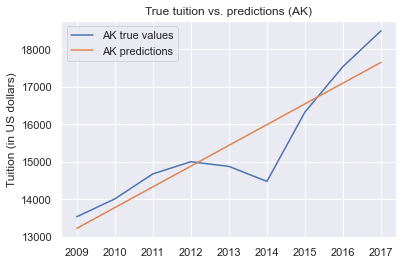

In [68]:
import matplotlib.pyplot as plt

plt.plot(years, AK_tuition, label='AK true values')
plt.plot(years, predict(years, AK_coeff), label='AK predictions')
plt.title('True tuition vs. predictions (AK)')
plt.ylabel('Tuition (in US dollars)')
plt.legend();

We can get predictions for 2018, or indeed several years, by supplying a NumPy array to our `predict` function.

In [69]:
predict(np.array([2018, 2019, 2020]), AK_coeff)

array([18201.11, 18754.33, 19307.55])

---
**Group Discussion**  
* What assumptions are we making in the model that we are building?  
* Why might the model for Alaska **not** be a suitable model for California, Florida, or other states?
---

Using our functions we have defined, we can build similar models for other states by repeating our calculations.  Trying Tennessee (TN), we seem to get better results than for Alaska.  

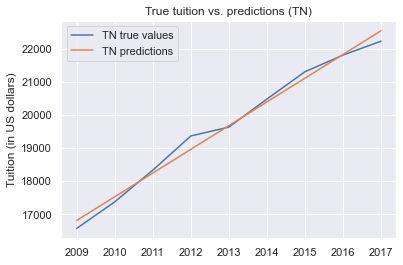

In [70]:
state = 'TN'

tuition = ave_tuitions.loc[state]
coef = linear_regression(years, tuition)

plt.plot(years, tuition, label=f'{state} true values')
plt.plot(years, predict(years, coef), label=f'{state} predictions')
plt.title(f'True tuition vs. predictions ({state})')
plt.ylabel('Tuition (in US dollars)')
plt.legend();

### Exercise
1. Change the value of `state` to get plots for other states (or territories, e.g. `GU` stands for "Guam" in the indices of `ave_tuition`).

## Repeating our calculation for each state

We want to repeat our calculation using the `linear_regression` method to get model coefficients (the $m$ and $b$ values) for each state.  Normally this is a situation where we would consider using the pandas `apply` method to apply a function `f` to each row of our `ave_tuitions` DataFrame, doing something like the following:
```Python
ave_tuitions.apply(f, axis=1)
```
How do we do this here?  

When we use `apply` on the rows, the argument that the function `f` receives is equal to what `loc` returns on a single row of the DataFrame.  Let's examine this value and see what we get for a single row.  

In [71]:
print(ave_tuitions.loc['AK'])
print()
print(type(ave_tuitions.loc['AK']))

year
2009    13532.67
2010    14007.67
2011    14674.00
2012    14999.50
2013    14874.67
2014    14475.00
2015    16325.00
2016    17536.50
2017    18490.00
Name: AK, dtype: float64

<class 'pandas.core.series.Series'>


The value returned by `loc` is a pandas `Series` object.  A Series has two components, the `index` of the Series and the `values` of the Series.  We want to use *both* of these components in our `linear_regression` method, namely setting `x` to equal the index (the year), and `y` equal to the values of the Series itself (the average tuition of the state for each year).  

With a little judicious sleight-of-hand, we can use a `lambda` function together with `linear_regression` to compute the model coefficients for each state.   

In [72]:
ave_tuitions.apply(lambda row: linear_regression(row.index.values, row.values), 
                   axis=1)['AK':'CT']

STABBR
AK    (553.2218333333333, -1098200.5493888888)
AL     (931.1716666666667, -1855510.523888889)
AR    (524.4768333333333, -1038070.1888333332)
AZ    (697.2896666666667, -1382035.3423333333)
CA     (617.0616666666667, -1220243.973888889)
CO             (727.6305, -1444412.5120555556)
CT    (578.6261666666668, -1146164.2568333338)
dtype: object

Finally, we can save the collection of coefficients for each state by creating a new variable or slicing in a new column to our `ave_tuitions` DataFrame if we wanted to keep all the information in one place.  Let's save them as a new variable, a pandas Series in this case.

In [73]:
coefficients = ave_tuitions.apply(lambda row: linear_regression(row.index.values, row.values), 
                             axis=1)

In [74]:
coefficients.head(10)

STABBR
AK    (553.2218333333333, -1098200.5493888888)
AL     (931.1716666666667, -1855510.523888889)
AR    (524.4768333333333, -1038070.1888333332)
AZ    (697.2896666666667, -1382035.3423333333)
CA     (617.0616666666667, -1220243.973888889)
CO             (727.6305, -1444412.5120555556)
CT    (578.6261666666668, -1146164.2568333338)
DC               (1432.9, -2865342.2555555557)
DE    (658.5333333333333, -1304521.5999999999)
FL     (454.6003333333334, -897047.2632222223)
dtype: object

Using `apply` to the `coefficients` Series (with the help of a `lambda` function), we can get predictions for 2018 for each state.  

In [75]:
predictions_2018 = coefficients.apply(lambda c: predict(np.array([2018]), c)[0])
predictions_2018.head(5)

STABBR
AK    18201.11
AL    23593.90
AR    20324.06
AZ    25095.21
CA    24986.47
dtype: float64

How do these compare to the real values for 2018?  Well, we actually have the data available for 2018, and can compute the average tuition for public universities that award undergraduate degrees to compare to our predictions.  We need to download that data first (this data wasn't included the previously downloaded Scorecard information).  

In [78]:
'''
%%bash
wget https://s3.amazonaws.com/dataincubator-course/college-scorecard/test/MERGED2018_19_PP.zip -nc -q -P CollegeScorecard_Data
'''

'\n%%bash\nwget https://s3.amazonaws.com/dataincubator-course/college-scorecard/test/MERGED2018_19_PP.zip -nc -q -P CollegeScorecard_Data\n'

In [77]:
tuitions_2018 = (avg_tuition_pub('CollegeScorecard_Data/MERGED2018_19_PP.zip', verbose=True)
                   .pipe(create_pivot))

Processing file: CollegeScorecard_Data/MERGED2018_19_PP.zip


In [79]:
print('Predictions for 2018: \n', predictions_2018.head())
print('\nReal values for 2018: \n', tuitions_2018.head())

Predictions for 2018: 
 STABBR
AK    18201.11
AL    23593.90
AR    20324.06
AZ    25095.21
CA    24986.47
dtype: float64

Real values for 2018: 
 year        2018
STABBR          
AK      19226.00
AL      22586.92
AR      20230.11
AZ      25023.43
CA      24831.25


We could further examine the predictions and real (average) tuition values to see how close they are, but this is where we are going to leave this machine learning "taster".  

*Copyright &copy; 2021 Hasnain*